In [1]:
import gc
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr, spearmanr

%load_ext autoreload
%autoreload 2

from delay_discounting_mvpa.config_loader import load_config
from delay_discounting_mvpa.fmri_io import load_bold_estimates
from delay_discounting_mvpa.io_utils import get_subids, load_tsv_data, resolve_file


## Quick reality check analysis

In this notebook, I focus on the **motor cortex** (using `Precentral_L_mask.nii.gz`) to examine **pattern dissimilarities** between trial pairs. Trials with the **same choice** (both Larger Later or both Smaller Sooner) should be more similar than trials with different choices.

I also examine correlations between **brain activation pattern dissimilarities** (Euclidean) and corresponding trial pair distances for two behavioral measures: **response time distances** (a potential confound) and **Later Delay distances** (a relationship of interest).

The notebook workflow:
- Starts with a single subject
- Loops through all subjects to generate a PDF of **pattern similarity matrices** and **scatterplots**
- At the end, shows:
  - Distributions of average distances for each pair type (SS, LL, SL)
  - Histograms of correlations across all subjects


In [2]:
config_file = '/oak/stanford/groups/russpold/data/uh2/aim1/analysis_code/delay_discounting_mvpa/configs/config.yaml'
cfg = load_config(config_file)

In [3]:
mask = Path(f'{cfg.masks_dir}/Precentral_L_mask.nii.gz')
mask.exists()

True

In [4]:
subids_txt_file = Path('../good_subjects/good_subids.txt')
with open(subids_txt_file, 'r') as f:
    subids = [line.strip() for line in f if line.strip()]

In [5]:
lsa_output_root = cfg.output_root / 'lsa_estimates'

In [6]:
subid = subids[10]
print(subid)
lsa_path = lsa_output_root / f'sub-{subid}_beta_series.nii.gz'
lsa_path.exists()

s497


True

In [7]:
roi_data, masker = load_bold_estimates(
    cfg, lsa_path, mask_type='roi', roi_mask_name='Precentral_L_mask.nii.gz'
)

In [8]:
behav_data_file = resolve_file(cfg, subid, 'behav')
behav_data = pd.read_csv(behav_data_file, sep='\t')

In [9]:
# metric='correlation' for correlation distance
# metric='euclidean' for euclidean
beta_dist_matrix = squareform(pdist(roi_data, metric='euclidean'))

# We shouldn't see a temporal pattern

Due the blockiness of the matrix below, I do have concerns about simply using similaries within-run between trials.  We shouldn't be seeing structure along the diagonal as shown below and in this case I believe it is due to a break that occurs about halfway through the scan and/or random ITIs that are slightly longer.

This is most certainly driven by collinearity. 

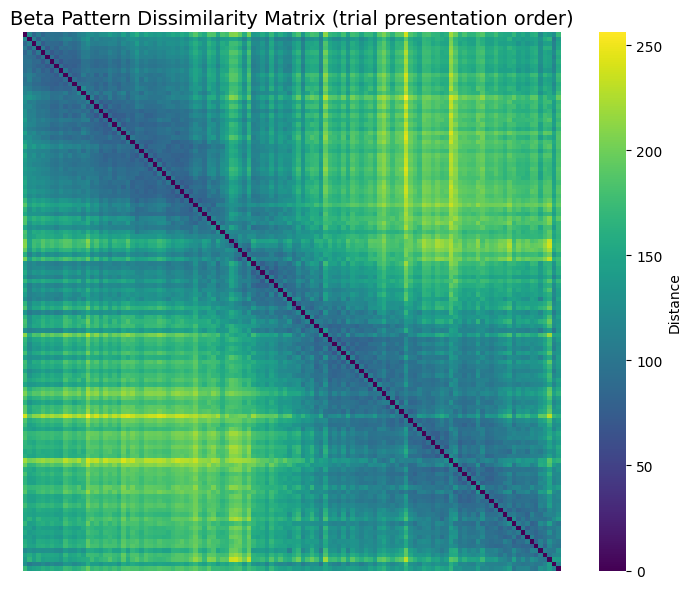

In [10]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    beta_dist_matrix,
    cmap='viridis',  # good perceptual colormap
    square=True,  # make cells square
    cbar_kws={'label': 'Distance'},  # label colorbar
    xticklabels=False,  # hide labels if many trials
    yticklabels=False,
)
plt.title('Beta Pattern Dissimilarity Matrix (trial presentation order)', fontsize=14)
plt.tight_layout()
plt.show()

In [11]:
choices = behav_data['choice'].to_numpy()

# Get indices for upper triangle of the matrix (excluding diagonal)
i_upper, j_upper = np.triu_indices_from(beta_dist_matrix, k=1)

# Identify the choice for each pair
choice_i = choices[i_upper]
choice_j = choices[j_upper]

# Create masks for pair categories
mask_ss = (choice_i == 'smaller_sooner') & (choice_j == 'smaller_sooner')
mask_ll = (choice_i == 'larger_later') & (choice_j == 'larger_later')
mask_sl = ((choice_i == 'smaller_sooner') & (choice_j == 'larger_later')) | (
    (choice_i == 'larger_later') & (choice_j == 'smaller_sooner')
)

# Extract distance values for each pairing
dist_ss = beta_dist_matrix[i_upper[mask_ss], j_upper[mask_ss]]
dist_ll = beta_dist_matrix[i_upper[mask_ll], j_upper[mask_ll]]
dist_sl = beta_dist_matrix[i_upper[mask_sl], j_upper[mask_sl]]

print(f'Smaller–Sooner pairs: {len(dist_ss)}')
print(f'Larger–Later pairs: {len(dist_ll)}')
print(f'Cross-type pairs: {len(dist_sl)}')

Smaller–Sooner pairs: 990
Larger–Later pairs: 2775
Cross-type pairs: 3375


In [12]:
print('Average distance between two smaller sooner maps')
print(np.mean(dist_ss))
print('Average distance between two larger later maps')
print(np.mean(dist_ll))
print('Average distance between a smaller sooner and larger later map')
print(np.mean(dist_sl))

Average distance between two smaller sooner maps
143.0918541898293
Average distance between two larger later maps
143.00415506560665
Average distance between a smaller sooner and larger later map
144.68207616537538


In [13]:
rt = behav_data['response_time'].values
rt_dist = squareform(pdist(rt[:, None], metric='euclidean'))


later_delay = behav_data['later_delay'].values
later_delay_dist = squareform(pdist(later_delay[:, None], metric='euclidean'))

In [14]:
i, j = np.triu_indices_from(rt_dist, k=1)  # will also work for beta

# Extract upper triangle values
rt_dist_vec = rt_dist[i, j]
beta_dist_vec = beta_dist_matrix[i, j]
later_delay_vec = later_delay_dist[i, j]

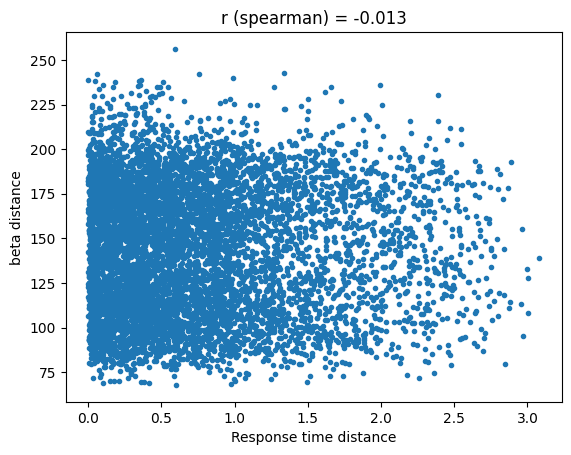

In [15]:
r, _ = spearmanr(rt_dist_vec, beta_dist_vec)

plt.plot(rt_dist_vec, beta_dist_vec, '.')
plt.xlabel('Response time distance')
plt.ylabel('beta distance')
plt.title(f'r (spearman) = {r:.3f}')

plt.show()

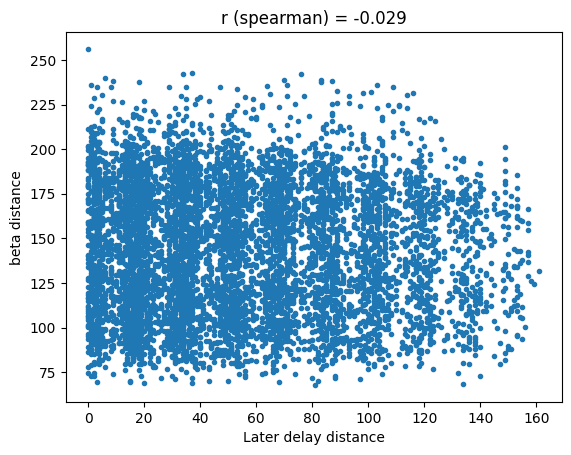

In [16]:
r, _ = spearmanr(later_delay_vec, beta_dist_vec)

plt.plot(later_delay_vec, beta_dist_vec, '.')
plt.xlabel('Later delay distance')
plt.ylabel('beta distance')
plt.title(f'r (spearman) = {r:.3f}')
plt.show()

## Run over everybody and arrange the above figures into a pdf

In [17]:
pdf_output_dir = Path(
    '/oak/stanford/groups/russpold/data/uh2/aim1/analysis_code/delay_discounting_mvpa/analyses/pattern_similarity_exploration'
)

In [18]:
all_subject_data = []

pdf_path = pdf_output_dir / 'all_subjects_figures.pdf'

with PdfPages(pdf_path) as pdf:
    for subid in subids:
        print(subid)
        # --- Load ROI beta series ---
        lsa_path = lsa_output_root / f'sub-{subid}_beta_series.nii.gz'
        roi_data, masker = load_bold_estimates(
            cfg, lsa_path, mask_type='roi', roi_mask_name='Precentral_L_mask.nii.gz'
        )

        # --- Load behavioral data ---
        behav_data_file = resolve_file(cfg, subid, 'behav')
        behav_data = pd.read_csv(behav_data_file, sep='\t')

        # --- Compute beta dissimilarity ---
        beta_dist_matrix = squareform(pdist(roi_data, metric='euclidean'))

        # --- Heatmap ---
        fig, ax = plt.subplots(figsize=(8, 6))
        sns.heatmap(
            beta_dist_matrix,
            cmap='viridis',
            square=True,
            cbar_kws={'label': 'Distance'},
            xticklabels=False,
            yticklabels=False,
            ax=ax,
        )
        ax.set_title(f'Sub-{subid} Beta Pattern Dissimilarity Matrix', fontsize=14)
        plt.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)

        # --- Choice pair distances ---
        choices = behav_data['choice'].to_numpy()
        i_upper, j_upper = np.triu_indices_from(beta_dist_matrix, k=1)
        choice_i = choices[i_upper]
        choice_j = choices[j_upper]

        mask_ss = (choice_i == 'smaller_sooner') & (choice_j == 'smaller_sooner')
        mask_ll = (choice_i == 'larger_later') & (choice_j == 'larger_later')
        mask_sl = ((choice_i == 'smaller_sooner') & (choice_j == 'larger_later')) | (
            (choice_i == 'larger_later') & (choice_j == 'smaller_sooner')
        )

        dist_ss = beta_dist_matrix[i_upper[mask_ss], j_upper[mask_ss]]
        dist_ll = beta_dist_matrix[i_upper[mask_ll], j_upper[mask_ll]]
        dist_sl = beta_dist_matrix[i_upper[mask_sl], j_upper[mask_sl]]

        # --- Response time and later delay distances ---
        rt_dist_vec = squareform(pdist(behav_data['response_time'].values[:, None]))
        rt_dist_vec = rt_dist_vec[np.triu_indices_from(rt_dist_vec, k=1)]

        beta_dist_vec = beta_dist_matrix[np.triu_indices_from(beta_dist_matrix, k=1)]

        later_delay_vec = squareform(pdist(behav_data['later_delay'].values[:, None]))
        later_delay_vec = later_delay_vec[np.triu_indices_from(later_delay_vec, k=1)]

        # --- Scatterplots: 1 row, 2 columns ---
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Panel 1: RT vs beta
        min_len = min(len(rt_dist_vec), len(beta_dist_vec))
        r1, _ = spearmanr(rt_dist_vec[:min_len], beta_dist_vec[:min_len])
        axes[0].plot(rt_dist_vec[:min_len], beta_dist_vec[:min_len], '.', alpha=0.5)
        axes[0].set_xlabel('Response time distance')
        axes[0].set_ylabel('Beta distance')
        axes[0].set_title(f'Sub-{subid} RT vs Beta, r={r1:.3f}')

        # Panel 2: Later delay vs beta
        min_len2 = min(len(later_delay_vec), len(beta_dist_vec))
        r2, _ = spearmanr(later_delay_vec[:min_len2], beta_dist_vec[:min_len2])
        axes[1].plot(
            later_delay_vec[:min_len2], beta_dist_vec[:min_len2], '.', alpha=0.5
        )
        axes[1].set_xlabel('Later delay distance')
        axes[1].set_ylabel('Beta distance')
        axes[1].set_title(f'Sub-{subid} Delay vs Beta, r={r2:.3f}')

        plt.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)

        # --- Cleanup ---
        del roi_data, beta_dist_matrix, behav_data
        gc.collect()

        all_subject_data.append(
            {
                'sub': subid,
                'SS': np.mean(dist_ss),
                'LL': np.mean(dist_ll),
                'SL': np.mean(dist_sl),
                'beta_dist_rt_dist_cor': r1,
                'beta_dist_delay_dist_cor': r2,
            }
        )


s061
s130
s172
s192
s234
s251
s358
s373
s471
s483
s497
s512
s518
s524


/oak/stanford/groups/russpold/data/uh2/aim1/analysis_code/delay_discounting_mvpa/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/oak/stanford/groups/russpold/data/uh2/aim1/analysis_code/delay_discounting_mvpa/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


s525
s526
s541
s546
s548
s549
s553
s554
s555
s556
s557
s561
s567
s568
s570
s573
s574
s577
s579
s581
s582
s583
s584
s585
s587
s589
s590
s591
s592
s593
s594
s595
s596
s597
s601
s602
s604
s606
s607
s609
s610
s611
s612
s613
s614
s615
s616
s617
s618
s621
s622
s623
s624
s626
s627
s628
s629
s631
s633
s634
s635
s636
s637
s638
s641
s642
s643
s644
s645
s648
s650


In [19]:
all_subject_df = pd.DataFrame(all_subject_data)

In [46]:
all_subject_df.mean(numeric_only=True)


SS                          255.596773
LL                          184.817181
SL                          224.301562
beta_dist_rt_dist_cor         0.045450
beta_dist_delay_dist_cor      0.003161
dtype: float64

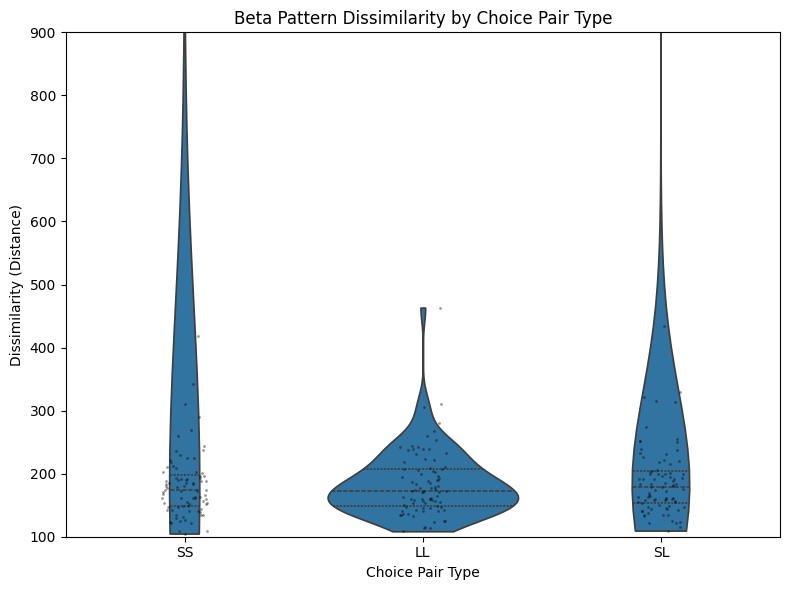

In [27]:
df_melted = all_subject_df.melt(
    id_vars='sub',
    value_vars=['SS', 'LL', 'SL'],
    var_name='Condition',
    value_name='Distance',
)

plt.figure(figsize=(8, 6))
sns.violinplot(
    x='Condition',
    y='Distance',
    data=df_melted,
    inner='quartile',
    legend=False,
    cut=0,
)
sns.stripplot(
    x='Condition',
    y='Distance',
    data=df_melted,
    color='k',
    alpha=0.4,
    size=2,
    jitter=True,
)
plt.ylim(100, 900)
plt.title('Beta Pattern Dissimilarity by Choice Pair Type')
plt.ylabel('Dissimilarity (Distance)')
plt.xlabel('Choice Pair Type')
plt.tight_layout()
plt.show()

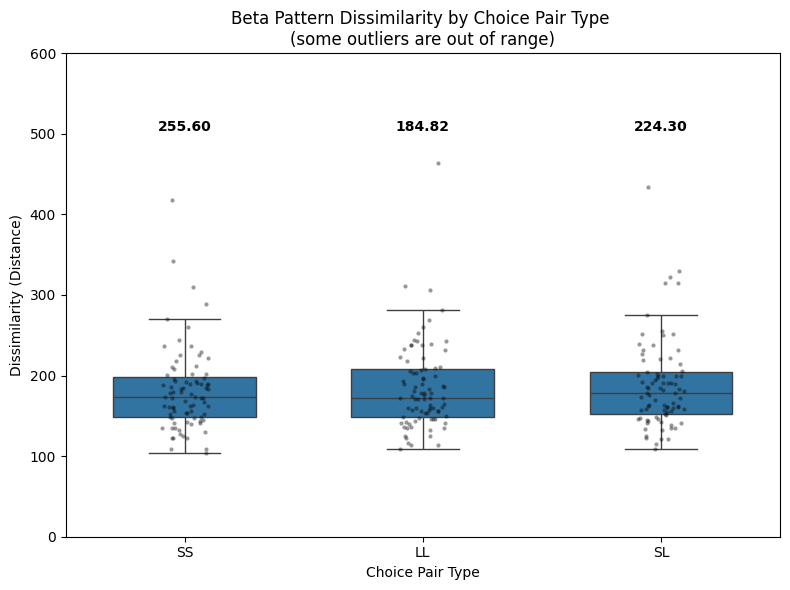

In [47]:
plt.figure(figsize=(8, 6))

order = ['SS', 'LL', 'SL']  # set your intended order explicitly

sns.boxplot(
    x='Condition',
    y='Distance',
    data=df_melted,
    showfliers=False,
    width=0.6,
    order=order,
)

sns.stripplot(
    x='Condition',
    y='Distance',
    data=df_melted,
    color='k',
    alpha=0.4,
    size=3,
    jitter=True,
    order=order,
)

# Add mean text above each boxplot in the correct order
group_means = df_melted.groupby('Condition')['Distance'].mean()
for i, cond in enumerate(order):
    mean_val = group_means[cond]
    plt.text(
        i,
        500,
        f'{mean_val:.2f}',
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold',
    )

plt.ylim(0, 600)
plt.title(
    'Beta Pattern Dissimilarity by Choice Pair Type \n(some outliers are out of range)'
)
plt.ylabel('Dissimilarity (Distance)')
plt.xlabel('Choice Pair Type')
plt.tight_layout()
plt.show()


In [49]:
from scipy.stats import ttest_rel
from itertools import combinations

print('\nPaired t-tests between conditions:')
for cond1, cond2 in combinations(order, 2):
    tstat, pval = ttest_rel(
        all_subject_df[cond1], all_subject_df[cond2], nan_policy='omit'
    )
    print(f'{cond1} vs {cond2}: t = {tstat:.3f}, p = {pval:.4f}')


Paired t-tests between conditions:
SS vs LL: t = 0.962, p = 0.3389
SS vs SL: t = 0.872, p = 0.3856
LL vs SL: t = -1.074, p = 0.2858


In [36]:
all_subject_df

,sub,SS,LL,SL,beta_dist_rt_dist_cor,beta_dist_delay_dist_cor
0,s061,184.773841,210.966921,199.605578,0.007340,-0.042884
1,s130,126.979365,134.277100,132.740744,0.008482,-0.011771
2,s172,144.720131,145.649368,147.467610,0.222964,0.054730
3,s192,142.352106,146.559863,143.800750,0.025169,0.006764
4,s234,210.849470,223.247020,220.358114,NaN,0.006886
...,...,...,...,...,...,...
80,s643,152.430832,149.021432,150.845917,NaN,0.010421
81,s644,217.785081,172.638178,205.040428,NaN,0.022901
82,s645,161.751467,156.490819,161.481842,0.037141,0.027307
83,s648,160.785602,156.118148,158.030595,0.067962,-0.017919


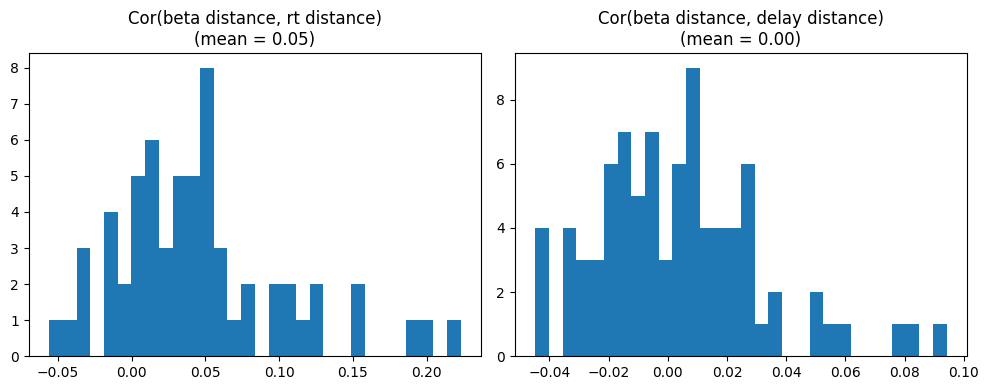

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Panel 1: RT distance
mean_cor1 = np.mean(all_subject_df['beta_dist_rt_dist_cor'])
axes[0].hist(all_subject_df['beta_dist_rt_dist_cor'], bins=30)
axes[0].set_title(f'Cor(beta distance, rt distance)\n(mean = {mean_cor1:.2f})')

# Panel 2: Delay distance
mean_cor2 = np.mean(all_subject_df['beta_dist_delay_dist_cor'])
axes[1].hist(all_subject_df['beta_dist_delay_dist_cor'], bins=30)
axes[1].set_title(f'Cor(beta distance, delay distance)\n(mean = {mean_cor2:.2f})')

plt.tight_layout()
plt.show()
